In [1]:
import findspark
#findspark.init('/afs/cern.ch/work/m/migliori/public/spark-2.4/')
findspark.init('/usr/hdp/spark/')

In [2]:
application_name = 'InclusiveClassifier-Training'
master = "yarn"
num_executors = 7
num_cores = 4

In [3]:
from pyspark.sql import SparkSession
import os 

os.environ["PYTHONHOME"] = "/afs/cern.ch/work/m/migliori/public/anaconda2"
os.environ["PYTHONPATH"] = "/afs/cern.ch/work/m/migliori/public/anaconda2/lib/python2.7/site-packages"

spark = SparkSession.builder\
        .appName(application_name)\
        .config("spark.pyspark.python",
                "/afs/cern.ch/work/m/migliori/public/anaconda2/bin/python")\
        .config("spark.master", master)\
        .config("spark.executor.cores",
                '{}'.format(num_cores))\
        .config("spark.executor.instances",
                '{}'.format(num_executors))\
        .config("spark.executor.memory",
                "{}G".format(6))\
        .config("spark.driver.memory",
                "{}G".format(3))\
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")\
        .getOrCreate()

In [4]:
data = spark.read.format("parquet") \
        .load("file:///afs/cern.ch/work/m/migliori/public/SparkPipeline/RNN_data.parquet/")
data.count()

58878

In [5]:
data.printSchema()

root
 |-- hfeatures: vector (nullable = true)
 |-- lfeatures: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- label: integer (nullable = true)
 |-- scaled_features: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)



In [6]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import MinMaxScaler

## One-Hot-Encode
encoder = OneHotEncoderEstimator(inputCols=["label"],
                                 outputCols=["encoded_label"],
                                 dropLast=False)

## Scale feature vector
scaler = MinMaxScaler(inputCol="hfeatures",
                      outputCol="hlf")

pipeline = Pipeline(stages=[encoder, scaler])

fitted_pipeline = pipeline.fit(data)

In [7]:
data = fitted_pipeline.transform(data)

In [8]:
train, test = data.randomSplit([0.8,0.2])

In [9]:
train = train.cache()
train.count()

47111

The inputs of the inclusive classifier are the High Lever Features `hlf` and the sequence of paricle flow candidates `scaled_features`.

In [10]:
data.printSchema()

root
 |-- hfeatures: vector (nullable = true)
 |-- lfeatures: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- label: integer (nullable = true)
 |-- scaled_features: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)
 |-- encoded_label: vector (nullable = true)
 |-- hlf: vector (nullable = true)



In [11]:
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Input, LSTM, Masking, GRU, concatenate
from keras import regularizers, optimizers

Using TensorFlow backend.


In [12]:
## Gru model
gru_input = Input(shape=(None, 19))
gru_layer = GRU(units=50,
              recurrent_dropout=0.2,
              activation='tanh')(gru_input)
gru_dropout = Dropout(0.5)(gru_layer)

## HLF classifier
hlf_input = Input(shape=(14,))
hlf_dropout = Dropout(0.5)(hlf_input)

## Concatenate the two models
concatenate_layer = concatenate([gru_dropout, hlf_dropout])
dense_layer = Dense(25, activation='relu')(concatenate_layer)
output_layer = Dense(3, activation='softmax')(dense_layer)

model = Model(inputs = [gru_input, hlf_input], outputs=output_layer)

In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 19)     0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 50)           10500       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 14)           0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 50)           0           gru_1[0][0]                      
__________________________________________________________________________________________________
dropout_2 

In [14]:
from distkeras.trainers import * 
from distkeras.predictors import *
from distkeras.utils import *
from distkeras.workers import *

In [15]:
optimizer = 'adam'
loss = 'categorical_crossentropy'

num_epochs = 50 
batch_size = 200

## set the number of workers
num_workers = num_executors

In [16]:
train = train.repartition(num_workers)

In [17]:
trainer = AEASGD(keras_model=model, worker_optimizer=optimizer,
                 loss=loss, num_workers=num_workers, batch_size=batch_size,
                 features_col=['scaled_features', 'hlf'], label_col="encoded_label", num_epoch=num_epochs,
                 communication_window=25, rho=5.0, learning_rate=0.1,
                 master_port=5500)
trainer.set_parallelism_factor(1)

In [18]:
%time trained_model = trainer.train(train)

CPU times: user 3min 21s, sys: 3min 38s, total: 7min
Wall time: 32min 50s


In [17]:
trainer_adag = ADAG(keras_model=model, worker_optimizer=optimizer, loss=loss,
                    num_workers=num_workers, batch_size=batch_size, communication_window=3,
                    num_epoch=num_epochs, features_col=['scaled_features', 'hlf'],
                    label_col="encoded_label", master_port=5600)
trainer_adag.set_parallelism_factor(1)

In [18]:
%time trained_model_adag = trainer_adag.train(train)

CPU times: user 4min 38s, sys: 6min 16s, total: 10min 55s
Wall time: 34min 9s


In [21]:
trainer_dsgd = DynSGD(keras_model=model, worker_optimizer=optimizer, loss=loss,
                    num_workers=num_workers, batch_size=batch_size,
                      features_col=['scaled_features', 'hlf'], label_col="encoded_label",
                      num_epoch=num_epochs, communication_window=5, master_port=5700)
trainer_dsgd.set_parallelism_factor(1)

In [22]:
%time trained_model_dsgd = trainer_dsgd.train(train)

Not executed
CPU times: user 6min 5s, sys: 8min 20s, total: 14min 26s
Wall time: 34min 54s


In [23]:
trainer_downpour = DOWNPOUR(keras_model=model, worker_optimizer=optimizer, loss=loss, num_workers=num_workers,
                   batch_size=batch_size, communication_window=5, num_epoch=num_epochs,
                   features_col=['scaled_features', 'hlf'], label_col="encoded_label", master_port=5800)
trainer_downpour.set_parallelism_factor(1)

In [24]:
%time trained_model_downpour  = trainer_downpour.train(train)

CPU times: user 5min 35s, sys: 8min 10s, total: 13min 45s
Wall time: 34min 41s


## Plot iterations and loss

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib notebook

In [26]:
worker_id = []
worker_iterations = []
worker_trainer = []

trainers_list = [trainer, trainer_adag, trainer_dsgd, trainer_downpour]
trainers_name = ['AEASGD', 'ADAG', 'DynSGD', 'DOWNPOUR']

for t, t_name in zip(trainers_list, trainers_name):
    for i in range(t.get_num_workers()):
        worker_id.append(i)
        worker_iterations.append(len(t.get_executor_history(i)))
        worker_trainer.append(t_name)
        
trainer_dataframe = pd.DataFrame({'worker_id':worker_id,
                                  'worker_iterations':worker_iterations,
                                  'trainer':worker_trainer})
trainer_dataframe.head()

,trainer,worker_id,worker_iterations
0,AEASGD,0,1650
1,AEASGD,1,1650
2,AEASGD,2,1650
3,AEASGD,3,1650
4,AEASGD,4,1650


<IPython.core.display.Javascript object>


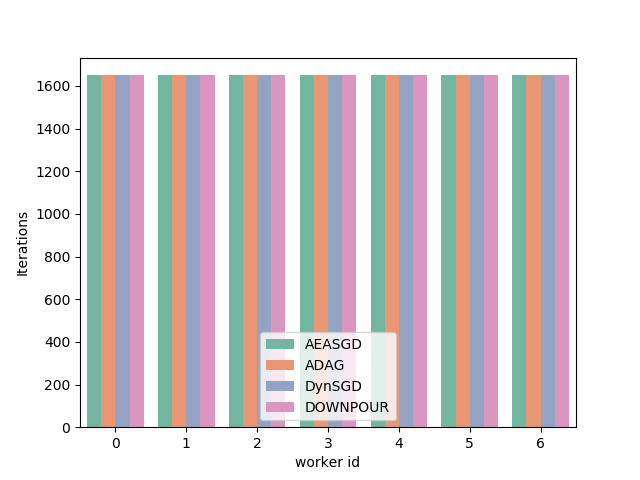

In [27]:
%matplotlib notebook 
plt.figure()
sns.barplot(x='worker_id', y='worker_iterations', hue='trainer',
              data=trainer_dataframe, palette="Set2")
plt.legend(loc='lower center')
plt.xlabel('worker id')
plt.ylabel('Iterations')
plt.show()

In [28]:
def compute_trainer_metrics(trainer):
    
    ## Get the history of each executor and find the max number of iterations
    num_workers = trainer.get_num_workers()
    max_iterations = 0
    
    history = []
    
    for i in range(num_workers):
        history.append(trainer.get_executor_history(i))
        if history[i][-1]['iteration']>max_iterations:
            max_iterations = history[i][-1]['iteration']
            
    iteration = []
    avg_loss = []
    std_loss = []

    ## Average the losses of batch_size iterations
    batch_loss = []
    batch_std = []
    
    for i in range(max_iterations):
        loss_i = [h[i]['history'][0] for h in history if i<len(h)]
        batch_loss.append(np.mean(loss_i))
        batch_std.append(np.std(loss_i))
    
        if (i%100==0) or (i==max_iterations-1):
            iteration.append(i)
            avg_loss.append(np.mean(batch_loss))
            std_loss.append(np.mean(batch_std))
            batch_loss = []
            batch_std = []
    
    iteration = np.asarray(iteration)
    loss = np.asarray(avg_loss)
    error = np.asarray(std_loss)
    
    return iteration, loss, error

In [29]:
x, y, err = compute_trainer_metrics(trainer)
x_adag, y_adag, err_adag = compute_trainer_metrics(trainer_adag)
x_dsgd, y_dsgd, err_dsgd = compute_trainer_metrics(trainer_dsgd)
x_downpour, y_downpour, err_downpour = compute_trainer_metrics(trainer_downpour)

<IPython.core.display.Javascript object>


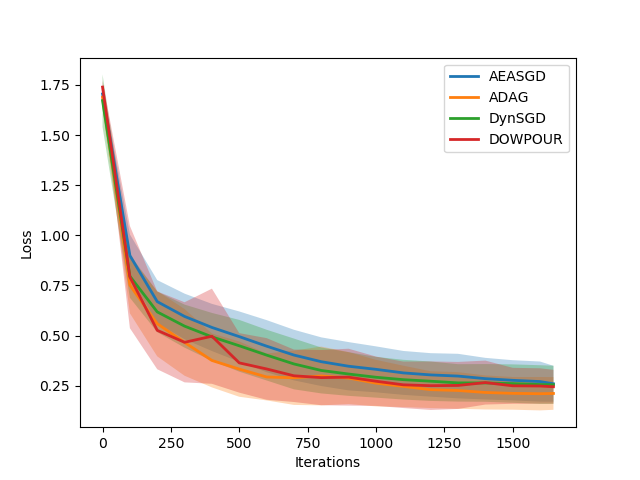

In [30]:
plt.figure()
plt.plot(x, y, lw=2, label='AEASGD')
plt.plot(x_adag, y_adag, lw=2, label='ADAG')
plt.plot(x_dsgd, y_dsgd, lw=2, label='DynSGD')
plt.plot(x_downpour, y_downpour, lw=2, label='DOWPOUR')
plt.fill_between(x, y - err , y + err, alpha=0.3)
plt.fill_between(x_adag, y_adag - err_adag,
                 y_adag + err_adag, alpha=0.3)
plt.fill_between(x_dsgd, y_dsgd - err_dsgd,
                 y_dsgd + err_dsgd, alpha=0.3)
plt.fill_between(x_downpour, y_downpour - err_downpour,
                 y_downpour + err_downpour, alpha=0.3)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Make predictions

In [19]:
predictor = ModelPredictor(keras_model=trained_model_adag, features_col=['scaled_features', 'hlf'])
pred = predictor.predict(test)

In [20]:
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.sql.functions import udf
    
vector_udf = udf(lambda vector: vector.toArray().tolist(),ArrayType(DoubleType()))
pred = pred.select([vector_udf('encoded_label').alias('encoded_label'),
                    vector_udf('prediction').alias('prediction')])

%time pred_pd = pred.toPandas()

CPU times: user 86.1 ms, sys: 23.1 ms, total: 109 ms
Wall time: 2min 22s


In [21]:
y_true = np.array(pred_pd['encoded_label'].tolist())
y_pred = np.array(pred_pd['prediction'].tolist())

In [22]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<IPython.core.display.Javascript object>


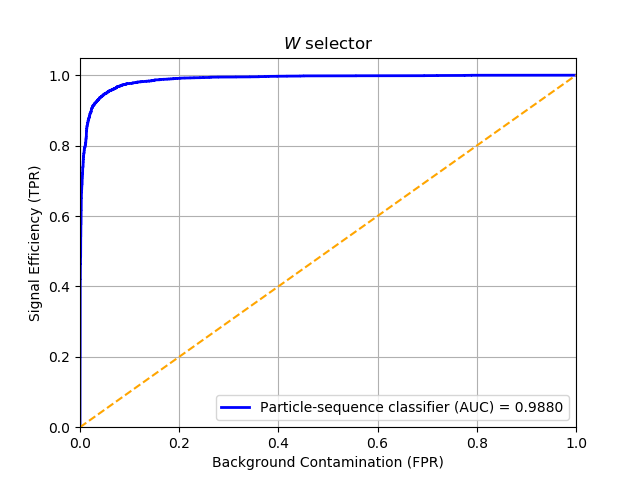

In [26]:
plt.figure()
plt.plot(fpr[1], tpr[1], color='blue',
         lw=2, label='Particle-sequence classifier (AUC) = %0.4f' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$W$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()